In [1]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 13.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt
env = gym.make("LunarLander-v2")
# env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x == 150)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


<h1>Train with two states from observation space<h1>

In [ ]:
epi = 5000

In [ ]:
#train with only two states
#very limited
#Q-Table given below
#state1: angle > 0
#state2: angle < 0
#action1: do nothing
#action2: fire left engine
#action3: fire main engine
#action4: fire right engine
#       action1 action2 action3 action4
#state1[a       b       c       d      ]
#state2[e       f       g       h      ]
Q = np.empty((2,env.action_space.n))
action = env.action_space.sample()
score = 0
epi_list=np.zeros(epi)
s_list=[]
s_avg=[]
for i in range(epi):
    state, info = env.reset(seed=0)
    state = 0 if state[4] > 0 else 1
    while True:
        if np.random.uniform() < 0.05:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = int(np.abs(next_state[0]))
        Q[state][action] = Q[state][action] + 0.9 * (reward + 0.1 * np.max(Q[next_state]) - Q[state][action])
        state = next_state
        score += reward
        if terminated or truncated:
            # print(f"Episode: {i} score: {score}")
            epi_list[i] = i
            s_list.append(score)
            s_avg.append(np.mean(s_list))
            score = 0
            break
env.close()

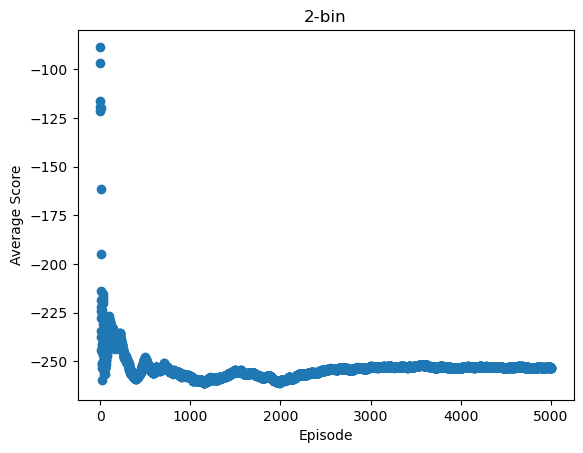

In [ ]:
plt.title("2-bin")
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.scatter(epi_list,s_avg)
plt.show()

<h1>Train with discretized observation space<h1>

In [3]:
number_of_bin = 8
def obs_to_state(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / number_of_bin
    a = int(max(0, min(number_of_bin-1, (obs[0] - env_low[0]) / env_dx[0])))
    b = int(max(0, min(number_of_bin-1, (obs[1] - env_low[1]) / env_dx[1])))
    c = int(max(0, min(number_of_bin-1, (obs[2] - env_low[2]) / env_dx[2])))
    d = int(max(0, min(number_of_bin-1, (obs[3] - env_low[3]) / env_dx[3])))
    e = int(max(0, min(number_of_bin-1, (obs[4] - env_low[4]) / env_dx[4])))
    f = int(max(0, min(number_of_bin-1, (obs[5] - env_low[5]) / env_dx[5])))
    h = 0 if int(np.abs(obs[6] - env_low[6])/env_dx[6]) < number_of_bin/2 else 1
    g = 0 if int(np.abs(obs[7] - env_low[7])/env_dx[7]) < number_of_bin/2 else 1
    state = (a,b,c,d,e,f,g,h)
    return state

In [12]:
episodes = 1000
epsilon = 0.01

In [5]:
#this is for clearing the window in render_mode = "human", no need to run this in google colab.
env.reset()
env.close()

In [13]:
Q = np.zeros((number_of_bin,number_of_bin,number_of_bin,number_of_bin,number_of_bin,number_of_bin,2,2,4))
action = env.action_space.sample()
score = 0
episode_list=np.zeros(episodes)
score_list=[]
score_avg=[]
for i in range(episodes):
    observation = env.reset(seed=0) #always use the asme seed when regenerating the terrian
    state = obs_to_state(env,observation)
    eta = max(0.001, 1 * (0.85 ** (i//100)))    #update learning rate
    while True:
        if np.random.uniform(0,1) < epsilon and np.mean(score_list) < 200:  #epsilon-greedy policy
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])
        next_observation, reward, terminated,  info = env.step(action)
        next_state = obs_to_state(env,next_observation)
        Q[state][action] = Q[state][action] + eta * (reward + 1 * np.max(Q[next_state]) - Q[state][action])
        state = next_state
        score += reward
        if terminated :
            episode_list[i] = i
            score_list.append(score)
            score_avg.append(np.mean(score_list))
            print(f"Episode: {i} score: {score}")
            print(f"Average: {np.mean(score_list)}")
            score = 0
            break
print(f"Average: {np.mean(score_list)}")
env.close()

Episode: 0 score: -225.0546179203594
Average: -225.0546179203594
Episode: 1 score: -191.98383398780737
Average: -208.51922595408337
Episode: 2 score: -231.4751673371838
Average: -216.17120641511687
Episode: 3 score: -45.19229590663859
Average: -173.4264787879973
Episode: 4 score: 20.932284176598912
Average: -134.55472619507805
Episode: 5 score: -140.50530615157544
Average: -135.54648952116096
Episode: 6 score: -226.9904826484774
Average: -148.6099171107776
Episode: 7 score: -222.87708232543608
Average: -157.89331276260987
Episode: 8 score: -182.74996738800306
Average: -160.65516327654245
Episode: 9 score: -268.90363320114716
Average: -171.48001026900292
Episode: 10 score: -49.65992442014711
Average: -160.40545701001602
Episode: 11 score: -190.08915169471638
Average: -162.87909823374105
Episode: 12 score: -225.22339299050367
Average: -167.6748132150305
Episode: 13 score: -43.61120673690932
Average: -158.81312703802183
Episode: 14 score: -92.23920814993362
Average: -154.37486577881597
Ep

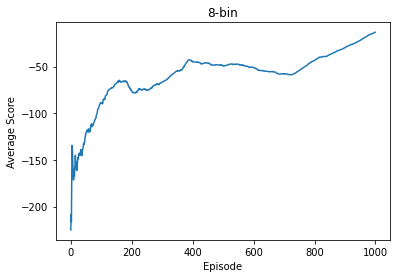

In [14]:
plt.title("8-bin")
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.plot(episode_list,score_avg)
plt.show()